# Desafío Data Science Nala 
## Aguirre Agustin L.

--------------------


----

## Desafio Nala - Fraud Detector & Insights

Imagine you’re already a crucial part of Nala’s team and that many business
decisions depend on the input you provide.

The challenge is to:

● EDA: Explore the data and present a thorough analysis

● Propose a categorization of the different customers

● Build a model that is capable of detecting fraudsters

● Put this model into production (locally or preferably in the cloud)

● Explain how good your model is, which are the most important features, and how the values of the variables influence in the model

● Explain the trade-off of using your model to detect fraudsters

● Push the project to a repo and share this with us. Include instructions and the packages to make the system replicable

● Share your most valuable insights of the data and the evidence of the model in production


## Dataset

El dataset que usamos puede encontrarse en https://drive.google.com/file/d/16Ao6U-67zMp-14JkksYTSb9rP04nLBvt/view EL mismo consiste de 26975 compras de diversos clientes en distintas circunstancias .




## Tabla de Contenidos

### [1- Imports]   

### [2- Base de datos]
  
  
### [3- EDA]



---

<a id="section_imports"></a> 
# 1- Imports

[volver a TOC](#section_toc)

In [22]:
import pandas as pd
import numpy as np
import os
import requests
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import plotly.express as px

<a id="section_dataset"></a> 
# 2- Base de datos

[volver a TOC](#section_toc)

<a id="section_carga"></a> 
### Carga del dataset
[volver a TOC](#section_toc)

In [85]:
dfn = pd.read_csv(r'DS Challenge.csv', sep=';')
df1n=dfn

In [86]:
dfn.dispositivo = dfn.dispositivo.str.replace(';', ',', regex = False)
dfn.dispositivo = dfn.dispositivo.str.replace("'", '"', regex = False)


In [87]:
y = json.loads(dfn.dispositivo[1])
type(y)

dict

In [88]:
dfn.dispositivo = dfn.dispositivo.apply(lambda  x : json.loads(x) if x != np.nan else x)


In [89]:
dfn['dispositivo_model'] = dfn.dispositivo.apply(lambda x : x['model'])
dfn['dispositivo_divice_score'] = dfn.dispositivo.apply(lambda x : x['device_score'])
dfn['dispositivo_os'] = dfn.dispositivo.apply(lambda x : x['os'])
dfn= dfn.drop(['dispositivo'], axis=1)
dfn['fechat']=dfn['fecha']
dfn['fecha'] =  pd.to_datetime(dfn['fecha'], infer_datetime_format=True)
dfn['dia'] = dfn['fecha'].apply(lambda x: x.day_name())




if(dfn['monto'].dtypes=='object'):
    dfn.monto = dfn.monto.str.replace(',', '.', regex = False) 
    dfn['monto'] = dfn['monto'].astype(float) 
if(dfn['dcto'].dtypes=='object'):
    dfn.dcto = dfn.dcto.str.replace(',', '.', regex = False) 
    dfn['dcto'] = dfn['dcto'].astype(float) 
if(dfn['cashback'].dtypes=='object'):
    dfn.cashback = dfn.cashback.str.replace(',', '.', regex = False) 
    dfn['cashback'] = dfn['cashback'].astype(float) 
if(dfn['ID_USER'].dtypes!='object'):
    dfn['ID_USER'] = dfn['ID_USER'].astype(str) 
    
    



## Análisis del dataset
[volver a TOC](#section_toc)

Dimensiones del dataset:

In [34]:
dfn.shape

(26975, 20)

In [35]:
dfn

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,dispositivo_model,dispositivo_divice_score,dispositivo_os,fechat,dia
0,0,F,608.345633,2020-01-21,20,Super,Merida,FÃ­sica,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID,21/01/2020,Tuesday
1,0,F,88.719243,2020-01-15,7,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,2020,1,ANDROID,15/01/2020,Wednesday
2,1,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,",",17/01/2020,Friday
3,1,F,767.005387,2020-01-05,11,MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB,5/01/2020,Sunday
4,1,F,254.171053,2020-01-30,10,NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%,30/01/2020,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,3999,M,746.192089,2020-01-08,13,NaN,Toluca,FÃ­sica,40000,56,Aceptada,False,0.000000,7.461921,False,2020,2,ANDROID,8/01/2020,Wednesday
26971,3999,M,941.804966,2020-01-14,15,NaN,Toluca,FÃ­sica,40000,56,Aceptada,False,0.000000,9.418050,False,2020,2,WEB,14/01/2020,Tuesday
26972,3999,M,251.189885,2020-01-16,11,NaN,Toluca,Virtual,40000,56,Aceptada,False,0.000000,5.023798,False,2020,2,WEB,16/01/2020,Thursday
26973,3999,M,24.182665,2020-01-13,17,NaN,Toluca,FÃ­sica,40000,56,Aceptada,False,2.418266,0.217644,False,2020,5,",",13/01/2020,Monday


Analizamos cuantos nulos posee cada feature .

In [36]:
dfn.isnull().sum()

ID_USER                         0
genero                          0
monto                           0
fecha                           0
hora                            0
establecimiento             10119
ciudad                      11678
tipo_tc                         0
linea_tc                        0
interes_tc                      0
status_txn                      0
is_prime                        0
dcto                            0
cashback                        0
fraude                          0
dispositivo_model               0
dispositivo_divice_score        0
dispositivo_os                  0
fechat                          0
dia                             0
dtype: int64

In [37]:
dfn.dtypes

ID_USER                             object
genero                              object
monto                              float64
fecha                       datetime64[ns]
hora                                 int64
establecimiento                     object
ciudad                              object
tipo_tc                             object
linea_tc                             int64
interes_tc                           int64
status_txn                          object
is_prime                              bool
dcto                               float64
cashback                           float64
fraude                                bool
dispositivo_model                    int64
dispositivo_divice_score             int64
dispositivo_os                      object
fechat                              object
dia                                 object
dtype: object

In [38]:
categorical_columnsn = [col for col in dfn.columns if dfn[col].dtypes == 'object']
for col in categorical_columnsn:
    print(f'\n{col}:\n{dfn[col].value_counts()}')


ID_USER:
1958    62
320     46
1361    42
2845    42
2414    40
        ..
410      1
2950     1
1324     1
3507     1
2715     1
Name: ID_USER, Length: 4000, dtype: int64

genero:
M     13519
F     10726
--     2730
Name: genero, dtype: int64

establecimiento:
Restaurante    3454
Abarrotes      3415
Super          3402
MPago          3343
Farmacia       3242
Name: establecimiento, dtype: int64

ciudad:
Toluca         3997
Guadalajara    3833
Merida         3761
Monterrey      3706
Name: ciudad, dtype: int64

tipo_tc:
FÃ­sica    18903
Virtual     8072
Name: tipo_tc, dtype: int64

status_txn:
Aceptada      18844
En proceso     5341
Rechazada      2790
Name: status_txn, dtype: int64

dispositivo_os:
%%         6808
WEB        6766
,          6715
ANDROID    6686
Name: dispositivo_os, dtype: int64

fechat:
29/01/2020    977
12/01/2020    969
24/01/2020    966
7/01/2020     961
30/01/2020    954
15/01/2020    952
5/01/2020     950
25/01/2020    946
17/01/2020    941
2/01/2020     940
18/0

Ahora se procede a testear si las variables numéricas se mueven en rangos que tienen sentido para cada tipo de variable.

In [39]:
numerical_columnsn = [col for col in dfn.columns if dfn[col].dtypes != 'object']
for col in numerical_columnsn:
    print(f'\n{col}:\nMínimo Valor:{dfn[col].min()}\nMáximo Valor:{dfn[col].max()}')


monto:
Mínimo Valor:0.017302513
Máximo Valor:999.9177636

fecha:
Mínimo Valor:2020-01-02 00:00:00
Máximo Valor:2020-01-30 00:00:00

hora:
Mínimo Valor:1
Máximo Valor:23

linea_tc:
Mínimo Valor:25000
Máximo Valor:99000

interes_tc:
Mínimo Valor:32
Máximo Valor:64

is_prime:
Mínimo Valor:False
Máximo Valor:True

dcto:
Mínimo Valor:0.0
Máximo Valor:199.3562512

cashback:
Mínimo Valor:0.00013842
Máximo Valor:19.99158233

fraude:
Mínimo Valor:False
Máximo Valor:True

dispositivo_model:
Mínimo Valor:2020
Máximo Valor:2020

dispositivo_divice_score:
Mínimo Valor:1
Máximo Valor:5


Se analiza una posible categorización de los clientes por su membresia "Prime"

In [40]:
dfn['is_prime'].value_counts()

False    23416
True      3559
Name: is_prime, dtype: int64

Se determina que no hay variables numéricas que tengan faltantes y/o datos que no tengan sentido teórico.

Veamos una posible categorización de los cliente por su género.


In [41]:
dfn.replace('--','X',inplace=True)
dfn['genero'].value_counts()

M    13519
F    10726
X     2730
Name: genero, dtype: int64

Ahora detectamos la cantidad de Fraudes en el dataset.

In [42]:
dfn['fraude'].value_counts()



False    26165
True       810
Name: fraude, dtype: int64

¿Qué pasa si borramos el total de filas con algun dato nulo?

In [60]:
totales_con_nulosn = dfn.genero.count()
print(f'Con nulos:\nTotales: {totales_con_nulosn}')
print(f'{dfn.genero.value_counts()}\n')

fig = px.pie(dfn,names='genero',title='Proporción Genero',hole=0.2, color_discrete_sequence=["blue", "green"])
fig.show()


dfn_nonulo=dfn.dropna()

totales_sin_nulosn = dfn_nonulo.genero.count()
print(f'Sin nulos:\nTotales: {totales_sin_nulosn}')
print(f'{dfn_nonulo.genero.value_counts()}\n')
print(f'Se pierde el {round(100*((+totales_con_nulosn - totales_sin_nulosn) / totales_con_nulosn) )} % de los datos de la variable target\n')

fig = px.pie(dfn_nonulo,names='genero',title='Proporción Genero',hole=0.2, color_discrete_sequence=px.colors.sequential.Hot)
fig.show()
#No se desbalancea tanto pero perdemos muchos datos target

Con nulos:
Totales: 26975
M    13519
F    10726
X     2730
Name: genero, dtype: int64



Sin nulos:
Totales: 9551
M    4902
F    3672
X     977
Name: genero, dtype: int64

Se pierde el 65.0 % de los datos de la variable target



In [61]:

totales_con_nulosn = dfn.is_prime.count()
print(f'Con nulos:\nTotales: {totales_con_nulosn}')
print(f'{dfn.is_prime.value_counts()}\n')

fig = px.pie(dfn,names='is_prime',title='Proporción Categoria  Prime',hole=0.2, color_discrete_sequence=["blue", "green"])
fig.show()

totales_sin_nulosn = dfn_nonulo.is_prime.count()
print(f'Sin nulos:\nTotales: {totales_sin_nulosn}')
print(f'{dfn_nonulo.is_prime.value_counts()}\n')
print(f'Se pierde el {round(100*((totales_con_nulosn - totales_sin_nulosn) / totales_con_nulosn) )} % de los datos de la variable target\n')

fig = px.pie(dfn_nonulo,names='is_prime',title='Proporción Categoria  Prime',hole=0.2, color_discrete_sequence=px.colors.sequential.Jet)
fig.show()
#No se desbalancea tanto pero perdemos muchos datos target

Con nulos:
Totales: 26975
False    23416
True      3559
Name: is_prime, dtype: int64



Sin nulos:
Totales: 9551
False    8247
True     1304
Name: is_prime, dtype: int64

Se pierde el 65.0 % de los datos de la variable target



Vamos a analizar algunas relaciones entre los datos:

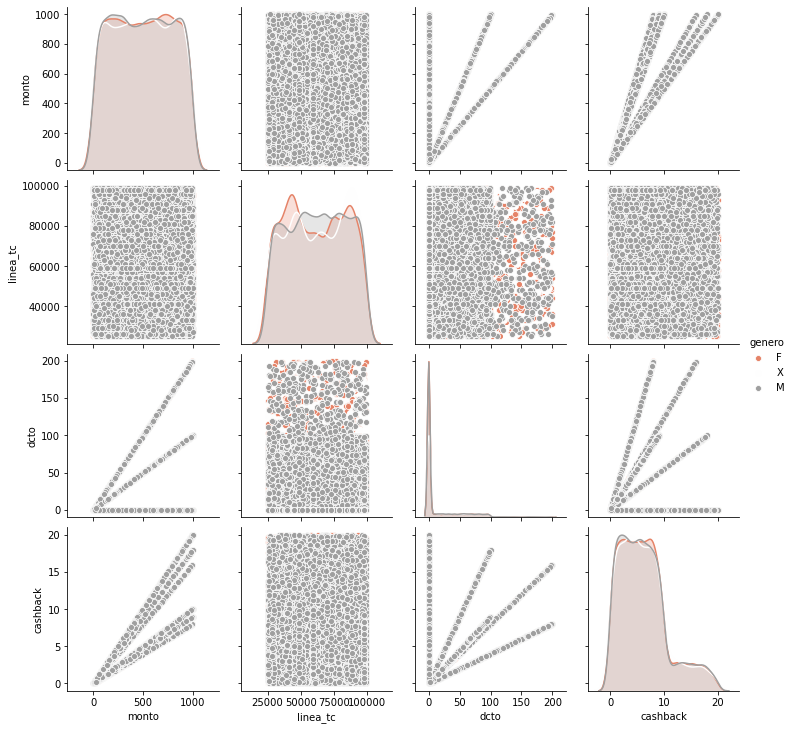

In [46]:
dfn2=dfn.dropna()
sns.pairplot(dfn[['genero','monto','linea_tc','dcto','cashback']],hue='genero', palette="RdGy");

Las caracteristicas observadas en los graficos no arrojan conclusiones excluyentes e inequívocas , motivo por el cual se necesita seguir explorando el dataset.

In [50]:
dfn.describe()

,monto,hora,linea_tc,interes_tc,dcto,cashback,dispositivo_model,dispositivo_divice_score
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.0,26975.000000
mean,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186,2020.0,3.002595
std,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440,0.0,1.417432
min,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,2020.0,1.000000
25%,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740,2020.0,2.000000
50%,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711,2020.0,3.000000
75%,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604,2020.0,4.000000
max,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,2020.0,5.000000


Ahora observamos las variables categoricas 

In [51]:

dfn.describe(include='object')

,ID_USER,genero,establecimiento,ciudad,tipo_tc,status_txn,dispositivo_os,fechat,dia
count,26975,26975,16856,15297,26975,26975,26975,26975,26975
unique,4000,3,5,4,2,3,4,29,7
top,1958,M,Restaurante,Toluca,FÃ­sica,Aceptada,%%,29/01/2020,Thursday
freq,62,13519,3454,3997,18903,18844,6808,977,4613


Ploteamos las distribuciones categoricas

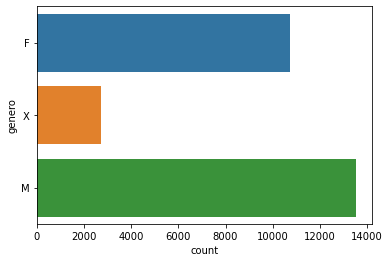

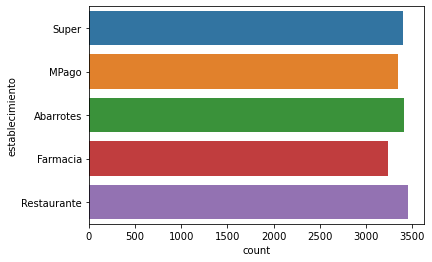

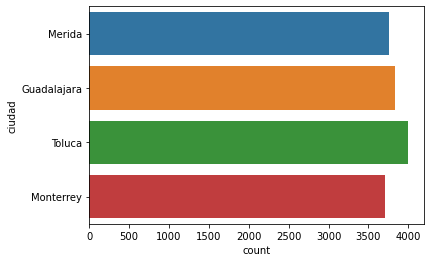

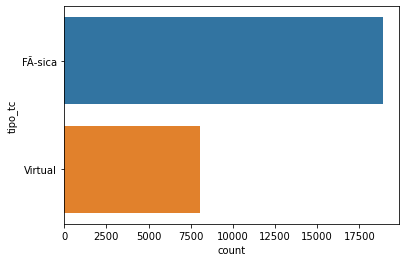

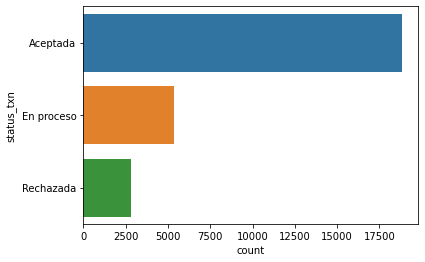

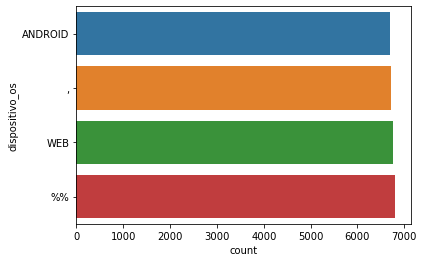

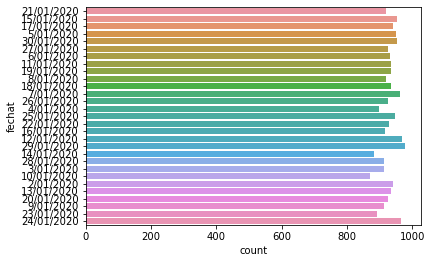

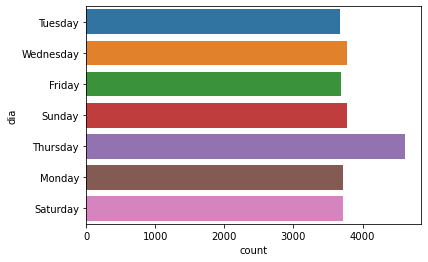

In [52]:

for col in dfn.select_dtypes(include='object'):
    if dfn[col].nunique() <= 31:
        sns.countplot(y=col, data=dfn)
        plt.show()

Apreciamos cual dia de la semana tuvo mayor cantidad de interacciones

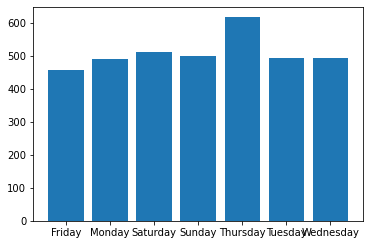

In [53]:
dfnn=dfn.copy()

def cm_to_inch(value):
    return value/2.54

counts = dfnn.groupby('dia')['is_prime'].sum()

plt.figure(figsize=(cm_to_inch(15), cm_to_inch(10)))
plt.bar(counts.index, counts  )
plt.show()

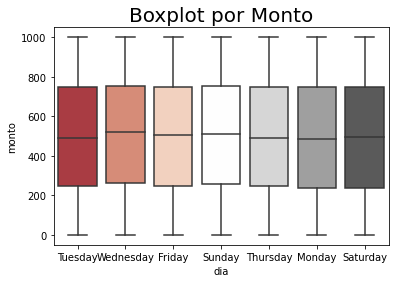

In [54]:
box=sns.boxplot(x="dia", y="monto", data=dfn,palette="RdGy")
box.set_title("Boxplot por Monto",size=20);


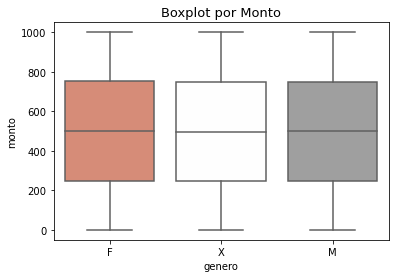

In [55]:
box2=sns.boxplot(x="genero", y="monto", data=dfn,palette="RdGy")
box2.set_title("Boxplot por Monto",size=13);

### Matriz de Correlacion para las variables numericas 

Esta matriz es de gran importancia, nos dice que tan fuerte estan correlacionadas dos variables entre si y pueden tomar valores entre -1 y 1 . La correlacion de una variable es 1 cuando se analiza consigo misma .

In [56]:
corr = dfn.corr()
corr

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,dispositivo_model,dispositivo_divice_score
monto,1.000000,-0.004348,-0.008415,0.014449,0.002188,0.286717,0.814530,-0.004239,NaN,-0.003524
hora,-0.004348,1.000000,0.003117,0.000413,-0.014709,0.002032,-0.009657,0.013376,NaN,-0.009411
linea_tc,-0.008415,0.003117,1.000000,-0.039932,0.014715,0.002777,-0.003100,-0.000488,NaN,0.005065
interes_tc,0.014449,0.000413,-0.039932,1.000000,-0.017794,0.003984,0.012961,-0.003130,NaN,-0.001843
is_prime,0.002188,-0.014709,0.014715,-0.017794,1.000000,0.004045,-0.003880,-0.004409,NaN,-0.004578
dcto,0.286717,0.002032,0.002777,0.003984,0.004045,1.000000,0.147308,-0.000735,NaN,0.005277
cashback,0.814530,-0.009657,-0.003100,0.012961,-0.003880,0.147308,1.000000,-0.004337,NaN,-0.002513
fraude,-0.004239,0.013376,-0.000488,-0.003130,-0.004409,-0.000735,-0.004337,1.000000,NaN,0.002130
dispositivo_model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dispositivo_divice_score,-0.003524,-0.009411,0.005065,-0.001843,-0.004578,0.005277,-0.002513,0.002130,NaN,1.000000


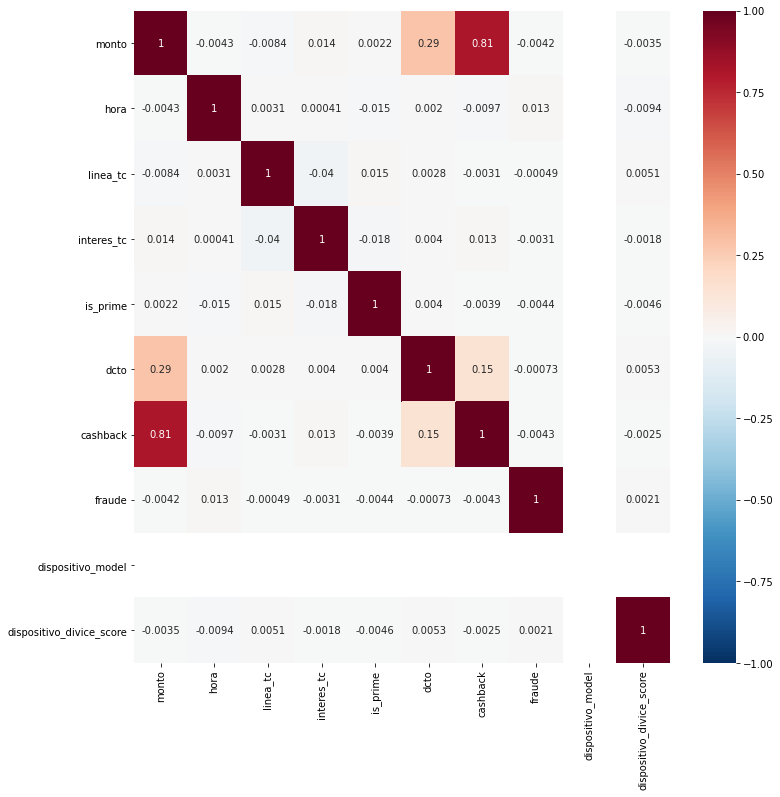

In [58]:

plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

In [ ]:
De esta Matriz podemos ver como estan fuertemente vinculadas las variables "Monto" y "Cashback"

El breve análisis realizado indica que hay diversos factores que afectan a cada transaccion , no arrojando una conclusion absoluta en el corto plazo
La seleccion del modelo juega un rol fundamental , por estar tan desbalanceado el dataset.
